**Import required libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns
import string



import numpy as np 
import pandas as pd

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
import re

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder


**Read Dataset**

In [ ]:
train=pd.read_csv("/content/drive/My Drive/DataSets/archive/Corona_NLP_train.csv",encoding='latin1');
test=pd.read_csv("/content/drive/My Drive/DataSets/archive/Corona_NLP_test.csv",encoding='latin1');

df = train.append(test, sort = False)

df.head()

df


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
3793,3794,48746,Israel ??,16-03-2020,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,3795,48747,"Farmington, NM",16-03-2020,Did you panic buy a lot of non-perishable item...,Negative
3795,3796,48748,"Haverford, PA",16-03-2020,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,3797,48749,NaN,16-03-2020,Gov need to do somethings instead of biar je r...,Extremely Negative


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 44955 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


**Sentiment Class Distribution**

In [ ]:
df_dist = df['Sentiment'].value_counts()

fig = go.Figure([go.Bar(x=df_dist.index, y=df_dist.values)])
fig.update_layout(title_text='Sentiment Distribution')
fig.show()


In [ ]:
def extract_hash_tags(s):
    hashes = re.findall(r"#(\w+)", s)
    return " ".join(hashes)
df['hashtags'] = df['OriginalTweet'].apply(lambda x : extract_hash_tags(x))

**Data Pre-processing (Cleaning, Tokenization)**

In [ ]:
tweet = df['OriginalTweet'].copy()
senti = df['Sentiment'].copy()

print(tweet.shape)
print(senti.shape)

#data cleaning
def clean_data(tweet):

  tweet = str(tweet).lower() #lowercase
  tweet = re.sub('\[.*?\]', '', tweet) #brackets
  tweet = re.sub('https?://\S+|www\.\S+', '', tweet) #URLs
  tweet = re.sub('<.*?>+', '', tweet) #punctuation
  tweet = re.sub('[%s]' % re.escape(string.punctuation), '', tweet) #punctuation
  tweet = re.sub('\n', '', tweet) #punctuation
  tweet = re.sub('\w*\d\w*', '', tweet) #punctuation
  return tweet

tweet_cleaned = tweet.apply(clean_data)
tweet_cleaned.head()


#tokenize the tweets
tok = Tokenizer()
tok.fit_on_texts(tweet_cleaned)

tweet = tok.texts_to_sequences(tweet_cleaned)

vocab_size = len(tok.word_index)+1

print("Vocabulary size: {}".format(vocab_size))
print("\nExample:\n")
print("Sentence:\n{}".format(tweet_cleaned[6]))
print("\nAfter tokenizing :\n{}".format(tweet[6]))



tweet = pad_sequences(tweet, padding='post')
print("\nAfter padding :\n{}".format(tweet[6]))
print(tweet.shape)

(44955,)
(44955,)
Vocabulary size: 74791

Example:

Sentence:
6    cashier at grocery store was sharing his insig...
6    voting in the age of coronavirus  hand sanitiz...
Name: OriginalTweet, dtype: object

After tokenizing :
[1189, 14, 21, 18, 69, 1420, 249, 800, 11, 2, 3042, 249, 11597, 188, 11598, 193, 6, 24892, 1597, 52, 13, 127, 63, 193, 961, 57]

After padding :
[ 1189    14    21    18    69  1420   249   800    11     2  3042   249
 11597   188 11598   193     6 24892  1597    52    13   127    63   193
   961    57     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
(44955, 61)


**Model Initialization and Structure**

In [ ]:
tf.keras.backend.clear_session()

# hyper parameters
epochs = 5
batch_size = 32
embed_dim = 16
units = 128

model = tf.keras.Sequential([
    L.Embedding(vocab_size, embed_dim, input_length=tweet.shape[1]),
    L.SimpleRNN(units,return_sequences=True),
    L.GlobalMaxPool1D(),
    L.Dropout(0.4),
    L.Dense(64, activation="relu"),
    L.Dropout(0.4),
    L.Dense(5)
])


model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 61, 16)            1196656   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 61, 128)           18560     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3

**Encoding and Model Training**

In [ ]:

encoder = LabelEncoder()
df['encoded_sentiment'] = encoder.fit_transform(df['Sentiment'])
senti = df['encoded_sentiment']

t_train, t_test, s_train, s_test = train_test_split(tweet,senti, test_size=0.3,stratify=senti)
print(t_train.shape,s_train.shape)
print(t_test.shape,s_test.shape)



(31468, 61) (31468,)
(13487, 61) (13487,)


In [ ]:
history = model.fit(t_train, s_train, epochs=epochs, validation_split=0.12, batch_size=batch_size)

Epoch 1/5
866/866 [==============================] - 31s 36ms/step - loss: 1.5257 - accuracy: 0.3020 - val_loss: 1.3444 - val_accuracy: 0.4130
Epoch 2/5
866/866 [==============================] - 32s 37ms/step - loss: 1.2643 - accuracy: 0.4689 - val_loss: 1.1358 - val_accuracy: 0.5346
Epoch 3/5
866/866 [==============================] - 35s 40ms/step - loss: 0.9795 - accuracy: 0.6090 - val_loss: 0.9586 - val_accuracy: 0.6235
Epoch 4/5
866/866 [==============================] - 33s 38ms/step - loss: 0.7745 - accuracy: 0.6987 - val_loss: 0.9268 - val_accuracy: 0.6534
Epoch 5/5
866/866 [==============================] - 32s 37ms/step - loss: 0.6391 - accuracy: 0.7563 - val_loss: 1.0243 - val_accuracy: 0.5902


**Evaluation with Test Data**

Test loss: 0.9993759393692017
Test Accuracy: 0.6119967103004456


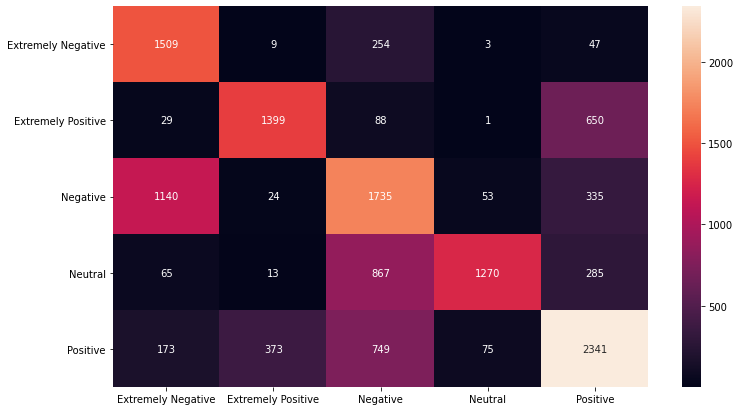

In [ ]:
#test the test data
pred = np.argmax(model.predict(t_test), axis=-1)


loss, acc = model.evaluate(t_test,s_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

conf = confusion_matrix(s_test, pred)

cm = pd.DataFrame(conf, index = list(encoder.classes_), columns = list(encoder.classes_))

plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [ ]:
from sklearn import metrics
labels = 
print(metrics.classification_report(t_test, s_test, target_names = encoder.fit))

SyntaxError: ignored